# Importing libs

In [ ]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU

In [ ]:
# We will set the seed for reproducibility.
np.random.seed(1234)
PYTHONHASHSEED = 0

# Load the Dataset

In [ ]:
# Training data where the last cycle is the failure point for the engines
train_df = pd.read_csv('Data/PM_train.txt', sep=" ", header=None)

# Test data where the failure point is not given for the engines
test_df = pd.read_csv('Data/PM_test.txt', sep=" ", header=None)

# We wil print some rows of the train data
train_df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,96,-0.0034,0.0001,100.0,518.67,642.19,1584.07,1395.16,14.62,...,8130.69,8.4311,0.03,392,2388,100.0,38.88,23.3255,NaN,NaN
96,1,97,0.0035,-0.0003,100.0,518.67,642.07,1595.77,1407.81,14.62,...,8128.74,8.4105,0.03,392,2388,100.0,39.01,23.2963,NaN,NaN
97,1,98,0.0006,0.0004,100.0,518.67,642.00,1591.11,1404.56,14.62,...,8127.89,8.4012,0.03,391,2388,100.0,38.96,23.2554,NaN,NaN
98,1,99,-0.0005,-0.0000,100.0,518.67,642.46,1592.73,1406.13,14.62,...,8131.77,8.4481,0.03,393,2388,100.0,38.82,23.2323,NaN,NaN


In [ ]:
# Let's drop the NAN columns 26 and 27 using the dropna() method.
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

In [ ]:
print(len(train_df))
print(len(test_df))

20631
13096


In [ ]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [ ]:
# Load the ground truth for the test data, which indicates the remaining useful cycles for the engines

truth_df = pd.read_csv('Data/PM_truth.txt', sep=" ", header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [ ]:
# We wil drop the NAN column
truth_df.dropna(axis=1, inplace=True)
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


Sort the data set by id and cycles so each engine can have its values sorted and stored in one place. We use the sort_values()


In [ ]:
# method and specify which columns are to be considered while sorting using the parameter.

train_df.sort_values(['id','cycle'], inplace=True)
test_df.sort_values(['id','cycle'], inplace=True)

First, we find the maximum cycles observed for each engine using groupby() and then merge these values for respective engine data using merge().

Then, we calculate the remaining useful life (RUL) by subtracting the current cycle value from the max. For example, a cycle has a total life of 192 cycles, and it has already run 50 cycles; hence, its RUL will be 192-50 = 142.



In [ ]:
# Extract the maximum number of cycles for each engine id.
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles) to calculate the remaining useful life.
train_df['RUL'] = train_df['max'] - train_df['cycle']

#The RUL is calculated for each id.
train_df[['id','cycle','max','RUL']].head()

,id,cycle,max,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [ ]:
# We do not need "max" anymore.
train_df.drop('max', axis=1, inplace=True)

Generate label column for training data

In [ ]:
# We will make a label that indicates whether an engine is going to fail within w1 cycles.
w1 = 30
train_df['failure_within_w1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

## Normalize Training Dataset

In [ ]:
# Make a separate feature for the normalized value of the cycle column.
train_df['cycle_norm'] = train_df['cycle']

# Using the difference function, we exclude these columns from the normalization process.
cols_normalize = train_df.columns.difference(['id','cycle','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)

#Join the normalized and non-normalized data.
join_df = train_df[['id','cycle','RUL','failure_within_w1']].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


Normalize the test data in the same manner that you normalized the training data.

In [ ]:
# We will perform MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']

# MinMax normalization (from 0 to 1) of the sensor data only
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)

#Join the normalized and non-normalized data (it does not have 'RUL' and 'failure_within_w1')
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

Label the test set like we did for the training data.

In [ ]:
# Let's calculate the total RUL by summing up the maximum cycles given in the test set and the
# ground truth additional RUL.
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['additional_rul']

# The respective id can be obtained by adding 1 to the index, as the index starts from 0.
truth_df['id'] = truth_df.index + 1

# Add the max cycles given in the test set and the additional RUL given in the ground truth DataFrame.
truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

# Generate the RUL for the test data.
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# Generate the label columns w0 and w1 for the test data.
test_df['failure_within_w1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,failure_within_w1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


# EDA
Let's see how the sensor values change for a particular engine id, say id=1.


<Axes: >

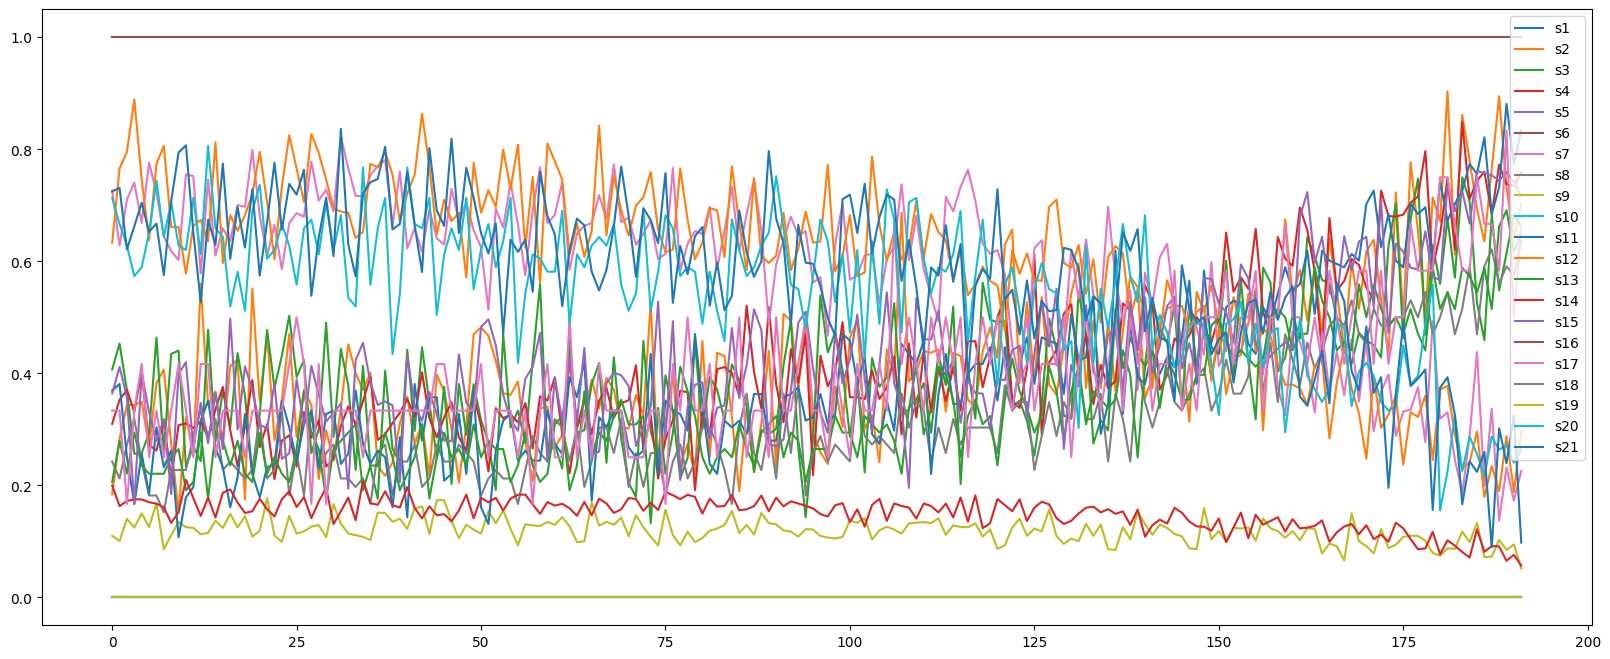

In [ ]:
sensor_cols = cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(20, 8))

<Axes: >

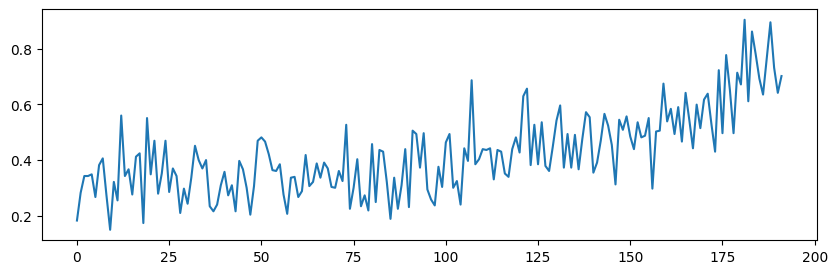

In [ ]:
train_df[train_df.id==1][sensor_cols[1]].plot(figsize=(10, 3))

* Sensor 1 values increase when the cycle of number incrceases.
* Sensor 6 values decrease when the cycle of number increases.
* Most other sensors exhibit either an increasing or decreasing trend.


<Axes: >

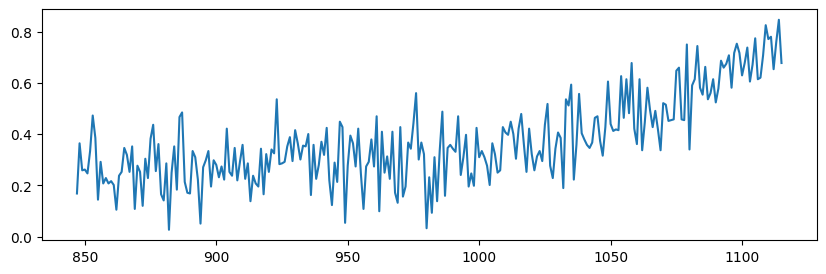

In [ ]:
train_df[train_df.id==5][sensor_cols[1]].plot(figsize=(10, 3))

<Axes: >

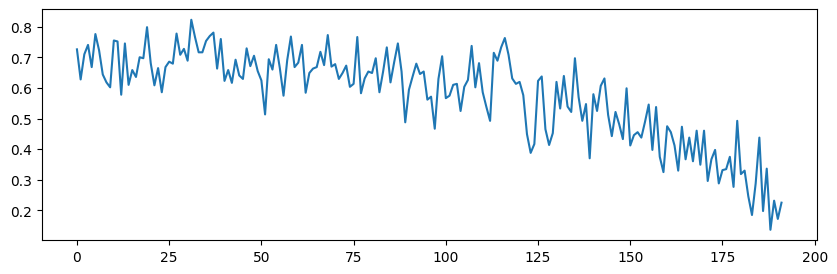

In [ ]:
train_df[train_df.id==1][sensor_cols[6]].plot(figsize=(10, 3))

We have plotted sensor1 observations for id 1 and id 5.

Both observations have an upward trend with increasing cycles.

<Axes: >

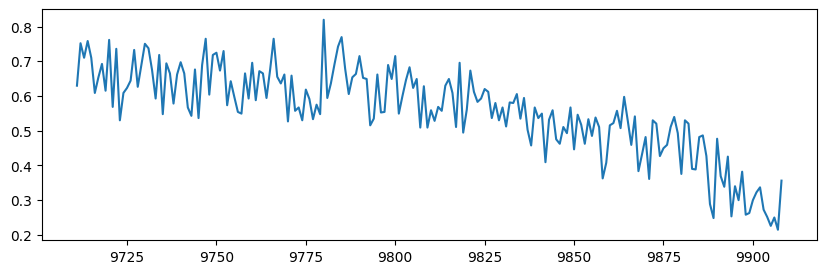

In [ ]:
train_df[train_df.id==50][sensor_cols[6]].plot(figsize=(10, 3))

We have plotted sensor6 observations for id 1 and id 50.

Both observations have a downward trend with increasing cycles.

We can sew that when the sensor values approach a particular value, the aircraft may fail to work soon.

# Generating Input Sequence


In [ ]:
# The sequence length to be used for predictions is as follows:
sequence_length = 50

In [ ]:
# The function to generate sequences (samples, time steps, features) for a particular engine id is as follows:

def sequence_generator(feature_df, seq_length, seq_cols):
    # We will not be using any sequence below seq_length.
    # Convert the DataFrame into a NumPy 2D array.
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]

    # We want to generate sequences of 50 timesteps at a time.
    # Hence, we will iterate over two sets of indices: (0,142),(50,192).
    # For example, id1 has 192 rows, and its sequence_length is equal to 50.
    # 0 50 -> From row 0 to row 50
    # 1 51 -> From row 1 to row 51
    # 2 52 -> From row 2 to row 52
    # ...
    # 141 191 -> From row 111 to 191

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [ ]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, ["s2"])) # We take only one feature (s2).
           for id in train_df['id'].unique())

# Concatenate the sequences of different engine ids into one array and convert that into a NumPy array
# [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
#print(list(seq_gen))
seq_set = np.concatenate(list(seq_gen)).astype(np.float32)

# Let’s print the shape of the seq_set  (number of samples, number of time steps, number of features)
seq_set.shape

(15631, 50, 1)

In [ ]:
# The function to generate labels is as follows:
def label_generator(label_df, seq_length, label):
    # Funtion will return
    # This function will return the following:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    # Convert the labels into a NumPy 2D array.

    label_array = label_df[label].values
    num_elements = label_array.shape[0]
        # Remove the first label, as the first prediction will be the (seq_length+1)th label.
    return label_array[seq_length:num_elements, :]

In [ ]:
# Generate labels [[142,1], [121, 1], [3]] --> [1, 2, 3] (ntotal, 1).
label_gen = [label_generator(train_df[train_df['id']==id], sequence_length, ['failure_within_w1'])
             for id in train_df['id'].unique()]
label_set = np.concatenate(label_gen).astype(np.float32)
label_set.shape

(15631, 1)

# RNN Models
We will build, train, and evaluate the following models:

* Simple RNN [1 Feature] <br>
* Simple RNN [25 Features] <br>
* Bi-Directional RNN [25 Features] <br>

## Simple RNN [1 Feature]

In [ ]:
out_dim = label_set.shape[1] # 1 label/output for one sequence.
features_dim = seq_set.shape[2] # Number of features (1)


print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd = Sequential()

# Add the RNN unit.
# Understand the parameters.
RNN_fwd.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=1,
         return_sequences=False))
RNN_fwd.add(Dropout(0.2))

RNN_fwd.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd.summary())

# Define the path to save the model.
RNN_fwd_path = 'Folder/RNN_fwd.keras'

Features dimension:  1
Output dimension:  1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
import time
epochs = 300
batch_size = 200
start = time.time()

# Fit the network.
RNN_fwd_history = RNN_fwd.fit(seq_set, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/300
75/75 - 5s - 71ms/step - accuracy: 0.3225 - loss: 0.9158 - val_accuracy: 0.1982 - val_loss: 0.8662
Epoch 2/300
75/75 - 2s - 21ms/step - accuracy: 0.3241 - loss: 0.8369 - val_accuracy: 0.1982 - val_loss: 0.7914
Epoch 3/300
75/75 - 0s - 5ms/step - accuracy: 0.3300 - loss: 0.7580 - val_accuracy: 0.3095 - val_loss: 0.7085
Epoch 4/300
75/75 - 0s - 5ms/step - accuracy: 0.5937 - loss: 0.6678 - val_accuracy: 0.9194 - val_loss: 0.6153
Epoch 5/300
75/75 - 0s - 5ms/step - accuracy: 0.8721 - loss: 0.5867 - val_accuracy: 0.8056 - val_loss: 0.5502
Epoch 6/300
75/75 - 0s - 5ms/step - accuracy: 0.8128 - loss: 0.5357 - val_accuracy: 0.8018 - val_loss: 0.5131
Epoch 7/300
75/75 - 0s - 5ms/step - accuracy: 0.8040 - loss: 0.5074 - val_accuracy: 0.8018 - val_loss: 0.4895
Epoch 8/300
75/75 - 0s - 6ms/step - accuracy: 0.8236 - loss: 0.4828 - val_accuracy: 0.8107 - val_loss: 0.4630
Epoch 9/300
75/75 - 0s - 6ms/step - accuracy: 0.8664 - loss: 0.4592 - val_accuracy: 0.8645 - val_loss: 0.4350
Epoch 10

**Model Evaluation on the Train and Validation Sets**

In [ ]:
# The function for plotting the change in the model’s accuracy on the train and validation sets is as follows:
def plot_model_accuracy(model_name_history, width = 10, height = 10):

  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['accuracy'])
  plt.plot(model_name_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

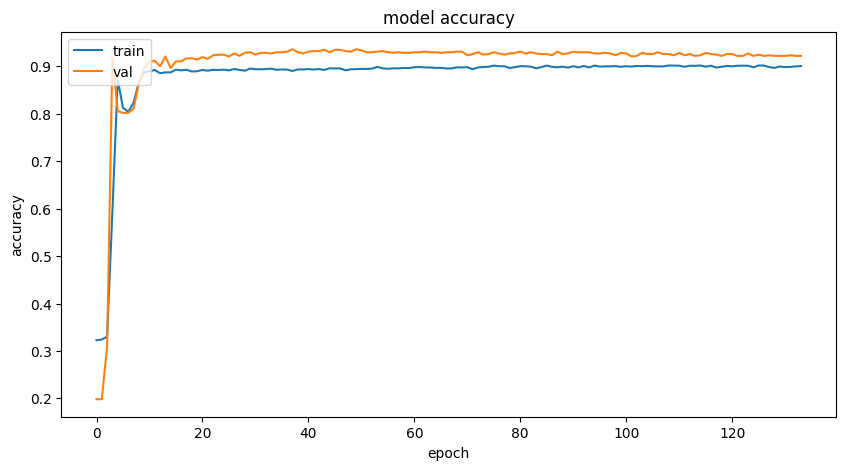

In [ ]:
#Call the function.
plot_model_accuracy(RNN_fwd_history,10,5)

**Training Curve**

In [ ]:
# We will define a function to plot the change in the loss on the train and validation sets.
def plot_training_curve(model_name_history, width = 10, height = 10):
  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['loss'])
  plt.plot(model_name_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

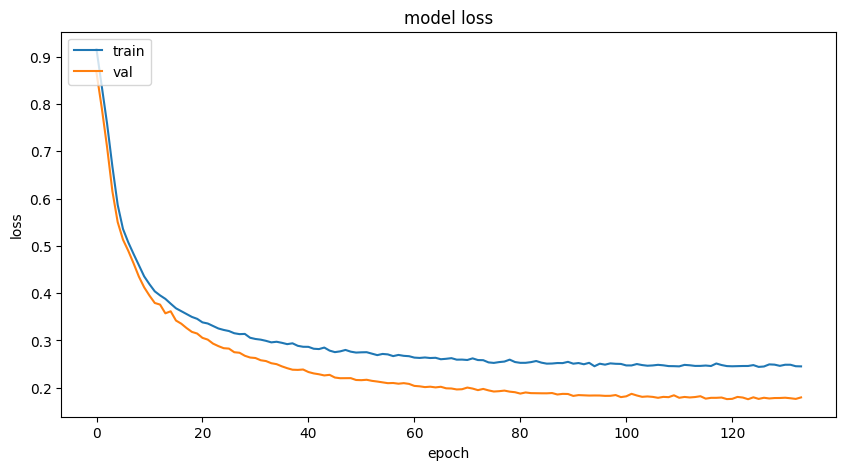

In [ ]:
#Call the function.
plot_training_curve(RNN_fwd_history,10,5)

**Model Evaluation on the Train Set**

In [ ]:
def analyze_model_on_train_set(input_sequence_set, model_name):

  # The training metrics are as follows:
  model_history_scores = model_name.evaluate(input_sequence_set, label_set, verbose=1, batch_size=50)
  print('Train Accurracy: {}'.format(model_history_scores[1]))

  # Make predictions and compute the confusion matrix.
  y_pred = (model_name.predict(input_sequence_set, verbose=1, batch_size=200) > 0.5).astype("int32")
  y_true = label_set

  test_set = pd.DataFrame(y_pred)
  test_set.to_csv('binary_submit_train.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_cm = confusion_matrix(y_true, y_pred)
  print(model_cm)

  # Compute the precision and recall.
  model_precision = precision_score(y_true, y_pred)
  model_recall = recall_score(y_true, y_pred)
  print( 'Train Precision = ', model_precision, '\n', 'Train Recall = ', model_recall)

# Call the function.
analyze_model_on_train_set(seq_set, RNN_fwd)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9293 - loss: 0.1860
Train Accurracy: 0.9270679950714111
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12193   338]
 [  802  2298]]
Train Precision =  0.8717754172989378 
 Train Recall =  0.7412903225806452


**Model evaluation on test set**

In [ ]:
def analyze_model_on_test_set(input_sequence_columns, model_path, width= 10, height=5):
  # We will consider all the last sequences of the test set.
  last_test_seq = [test_df[test_df['id']==id][input_sequence_columns].values[-sequence_length:]
                        for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
  last_test_seq = np.asarray(last_test_seq).astype(np.float32)

  # Get the labels of the test set.
  y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
  last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
  last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

  # If the best model weights were saved, load them.
  if os.path.isfile(model_path):
    print("using " + model_path)
    model_estimator = load_model(model_path)

  # Test the metrics.
  start = time.time()
  scores_test = model_estimator.evaluate(last_test_seq, last_test_label, verbose=2)
  end = time.time()
  print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

  print('Test Accurracy: {}'.format(scores_test[1]))

  # Make predictions and compute the confusion matrix.
  y_model_estimator_pred_test = (model_estimator.predict(last_test_seq) >0.5).astype("int32")
  y_true_test = last_test_label

  test_set = pd.DataFrame(y_model_estimator_pred_test)
  test_set.to_csv('binary_submit_test.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_estimator_conf_m = confusion_matrix(y_true_test, y_model_estimator_pred_test)
  print(model_estimator_conf_m)

  # Compute the precision and recall values.
  model_estimator_precision_test = precision_score(y_true_test, y_model_estimator_pred_test)
  model_estimator_recall_test = recall_score(y_true_test, y_model_estimator_pred_test)
  f1_test = 2 * (model_estimator_precision_test * model_estimator_recall_test) / (model_estimator_precision_test + model_estimator_recall_test)
  print( 'Test Precision: ', model_estimator_precision_test, '\n', 'Test Recall: ', model_estimator_recall_test,'\n', 'Test F1-score:', f1_test )

  # Plot the predicted data in blue and the
  # actual data in green to visually verify the accuracy of the model.
  fig_verify = plt.figure(figsize=(10, 5))
  plt.plot(y_model_estimator_pred_test, color="blue")
  plt.plot(y_true_test, color="green")
  plt.title('prediction')
  plt.ylabel('value')
  plt.xlabel('row')
  plt.legend(['predicted', 'actual data'], loc='upper left')
  plt.show()

using Folder/RNN_fwd.keras
3/3 - 1s - 272ms/step - accuracy: 0.9032 - loss: 0.2715
Total time taken for inferencing:  1.00  secs
Test Accurracy: 0.9032257795333862
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 8 17]]
Test Precision:  0.9444444444444444 
 Test Recall:  0.68 
 Test F1-score: 0.7906976744186047


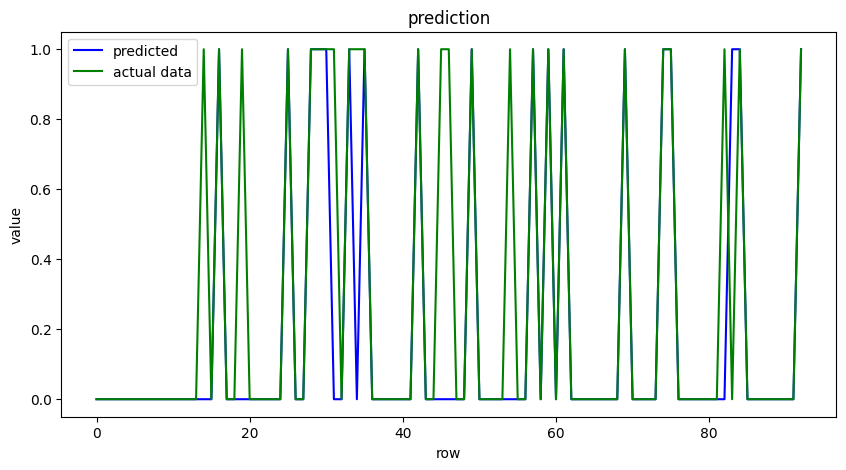

In [ ]:
#Call the function.
analyze_model_on_test_set(["s2"], RNN_fwd_path, 10, 5)

## Simple RNN With 25 Features
Let's now consider data from all 21 sensors and 3 settings as well.
This will lead to 25 features in the input sequence set.

In [ ]:
# Pick the feature columns.
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols_25 = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols_25.extend(sensor_cols) # Add the elements of sensor_cols into sequence_cols.

In [ ]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, sequence_cols_25)) #We will take all the features (25).
           for id in train_df['id'].unique())

# Concatenate the sequences of the different engine ids into one and convert it into a NumPy array [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
seq_set_f25 = np.concatenate(list(seq_gen)).astype(np.float32)

#The shape denotes (number of samples, number of time steps, number of features).
seq_set_f25.shape

(15631, 50, 25)

In [ ]:
features_dim = seq_set_f25.shape[2] # number of features (25).
out_dim = label_set.shape[1] # One label (failure_within_w1).

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd_2 = Sequential()

# Understanding return_sequences and the connection across RNN layers:
# We have to return the sequences from the first layer so the next layer can get the sequence.

RNN_fwd_2.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=5,
         return_sequences=True))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd_2.summary())

# Define the path to save the model.
RNN_fwd_2_path = 'Folder/RNN_fwd_2.keras'

Features dimension:  25
Output dimension:  1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 50, 5)               │             155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 3)                   │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186 (744.00 B)

 Trainable params: 186 (744.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network.
RNN_fwd_2_history = RNN_fwd_2.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_2_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/200
75/75 - 10s - 129ms/step - accuracy: 0.6926 - loss: 0.6033 - val_accuracy: 0.8018 - val_loss: 0.5386
Epoch 2/200
75/75 - 3s - 45ms/step - accuracy: 0.8017 - loss: 0.5395 - val_accuracy: 0.8018 - val_loss: 0.5143
Epoch 3/200
75/75 - 1s - 10ms/step - accuracy: 0.8017 - loss: 0.5200 - val_accuracy: 0.8018 - val_loss: 0.4992
Epoch 4/200
75/75 - 1s - 10ms/step - accuracy: 0.8718 - loss: 0.4214 - val_accuracy: 0.9258 - val_loss: 0.3200
Epoch 5/200
75/75 - 1s - 10ms/step - accuracy: 0.9279 - loss: 0.3154 - val_accuracy: 0.9297 - val_loss: 0.2760
Epoch 6/200
75/75 - 1s - 17ms/step - accuracy: 0.9291 - loss: 0.2833 - val_accuracy: 0.9284 - val_loss: 0.2512
Epoch 7/200
75/75 - 1s - 10ms/step - accuracy: 0.9345 - loss: 0.2554 - val_accuracy: 0.9258 - val_loss: 0.2423
Epoch 8/200
75/75 - 1s - 11ms/step - accuracy: 0.9352 - loss: 0.2400 - val_accuracy: 0.9271 - val_loss: 0.2249
Epoch 9/200
75/75 - 1s - 19ms/step - accuracy: 0.9353 - loss: 0.2277 - val_accuracy: 0.9309 - val_loss: 0.2075

**Plot Model Accuracy for the Train and Validation Sets**

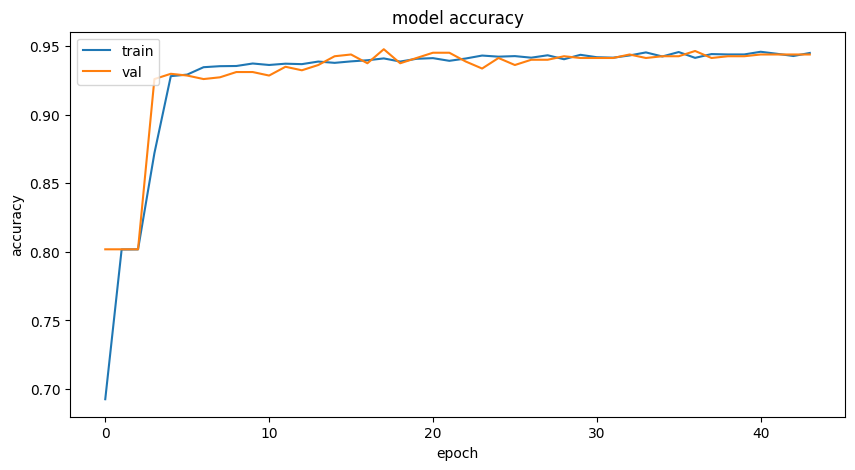

In [ ]:
plot_model_accuracy(RNN_fwd_2_history, 10, 5)

**Training Curve**

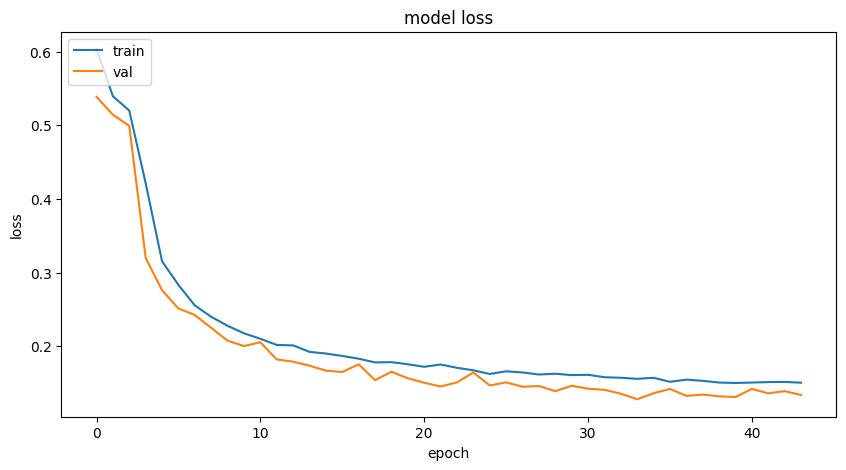

In [ ]:
plot_training_curve(RNN_fwd_2_history,10,5)

**Model Evaluation on Train Set**

In [ ]:
analyze_model_on_train_set(seq_set_f25, RNN_fwd_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9532 - loss: 0.1145
Train Accurracy: 0.9490755796432495


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12234   297]
 [  499  2601]]
Train Precision =  0.8975155279503105 
 Train Recall =  0.8390322580645161


**Model Evaluation on Test Set**

using Folder/RNN_fwd_2.keras
3/3 - 1s - 442ms/step - accuracy: 0.9355 - loss: 0.2123
Total time taken for inferencing:  1.37  secs
Test Accurracy: 0.9354838728904724
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 5 20]]
Test Precision:  0.9523809523809523 
 Test Recall:  0.8 
 Test F1-score: 0.8695652173913043


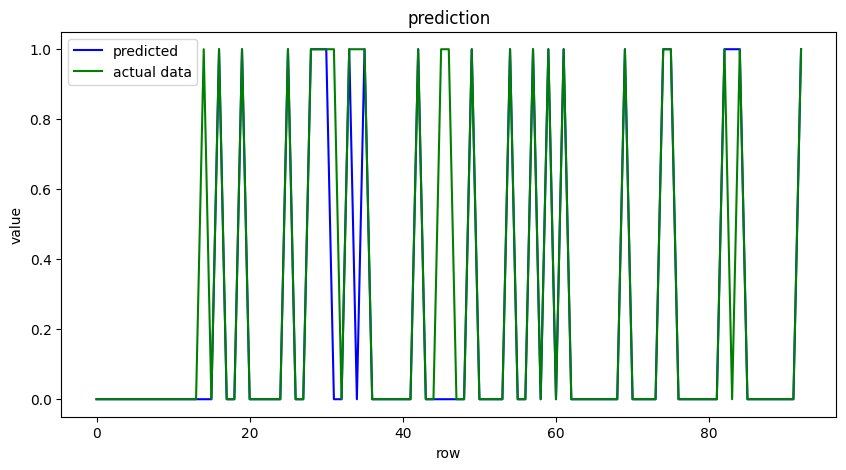

In [ ]:
analyze_model_on_test_set(sequence_cols_25, RNN_fwd_2_path, 10, 5)

## Bidirectional RNN

You saw how to build ForwardRNN models with SimpleRNN units.

Let's now create a bidirectional RNN model.


In [ ]:
#Import a bidirectional library.
from tensorflow.keras.layers import Bidirectional

features_dim = seq_set_f25.shape[2] # Number of features (25)
out_dim = label_set.shape[1] # One output for each sequence (failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_bi = Sequential()

# Understanding return_sequences and the connection across RNN layers
# Note that we have to return the sequence from the first layer so the next layer can get the sequence.

RNN_bi.add(Bidirectional( #We need to pass the RNN unit as an argument of the Bidirectional() function.
         SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=6,
         return_sequences=True)))
RNN_bi.add(Dropout(0.2))

RNN_bi.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_bi.add(Dropout(0.2))

RNN_bi.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the path to save the model.
RNN_bi_path = 'Folder/RNN_bi.keras'

Features dimension:  25
Output dimension:  1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network
RNN_bi_history = RNN_bi.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_bi_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")



Epoch 1/200
75/75 - 11s - 149ms/step - accuracy: 0.7962 - loss: 0.5184 - val_accuracy: 0.8018 - val_loss: 0.4597
Epoch 2/200
75/75 - 4s - 53ms/step - accuracy: 0.8100 - loss: 0.4644 - val_accuracy: 0.8018 - val_loss: 0.3951
Epoch 3/200
75/75 - 2s - 21ms/step - accuracy: 0.8820 - loss: 0.3451 - val_accuracy: 0.9258 - val_loss: 0.2538
Epoch 4/200
75/75 - 2s - 28ms/step - accuracy: 0.9256 - loss: 0.2657 - val_accuracy: 0.9258 - val_loss: 0.2396
Epoch 5/200
75/75 - 1s - 15ms/step - accuracy: 0.9299 - loss: 0.2372 - val_accuracy: 0.9297 - val_loss: 0.2035
Epoch 6/200
75/75 - 1s - 15ms/step - accuracy: 0.9325 - loss: 0.2215 - val_accuracy: 0.9297 - val_loss: 0.1973
Epoch 7/200
75/75 - 1s - 17ms/step - accuracy: 0.9335 - loss: 0.2066 - val_accuracy: 0.9322 - val_loss: 0.1855
Epoch 8/200
75/75 - 1s - 16ms/step - accuracy: 0.9331 - loss: 0.2010 - val_accuracy: 0.9309 - val_loss: 0.1803
Epoch 9/200
75/75 - 1s - 15ms/step - accuracy: 0.9345 - loss: 0.1946 - val_accuracy: 0.9361 - val_loss: 0.1614

In [ ]:
#Print the summary of the model.
print(RNN_bi.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 50, 12)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50, 12)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 3)                   │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,310 (5.12 KB)

 Trainable params: 436 (1.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 874 (3.42 KB)

None


**Plot model accuracy for train and validation set**

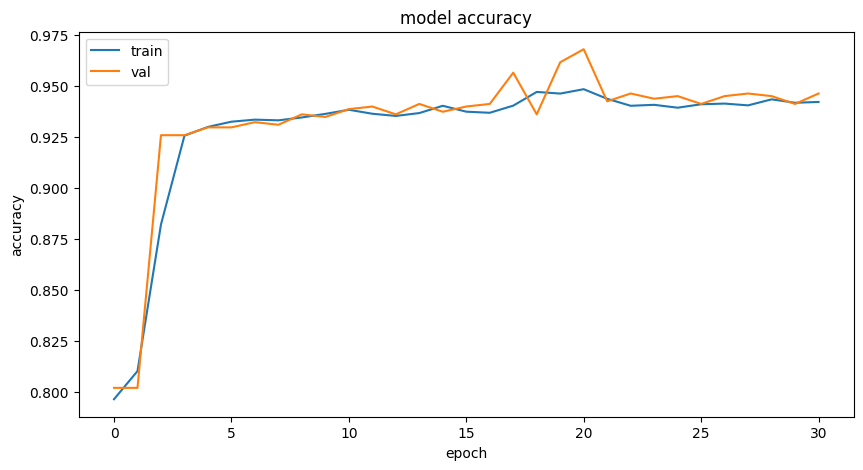

In [ ]:
plot_model_accuracy(RNN_bi_history,10,5)

**Training curve**

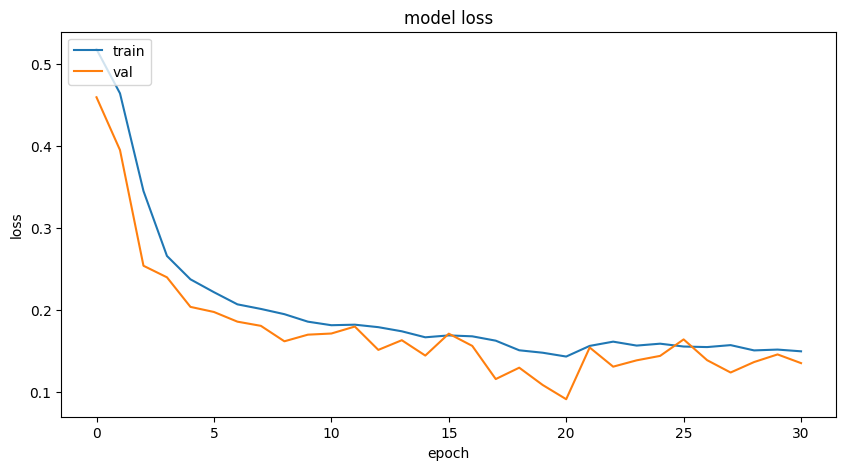

In [ ]:
plot_training_curve(RNN_bi_history,10,5)

**Model Evaluation on train set**

In [ ]:
analyze_model_on_train_set(seq_set_f25, RNN_bi)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9505 - loss: 0.1170
Train Accurracy: 0.9477320909500122


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12303   228]
 [  589  2511]]
Train Precision =  0.9167579408543264 
 Train Recall =  0.81


**Model Evaluation on test set**

using Folder/RNN_bi.keras
3/3 - 2s - 526ms/step - accuracy: 0.9140 - loss: 0.1607
Total time taken for inferencing:  1.92  secs
Test Accurracy: 0.9139785170555115
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 6 19]]
Test Precision:  0.9047619047619048 
 Test Recall:  0.76 
 Test F1-score: 0.8260869565217391


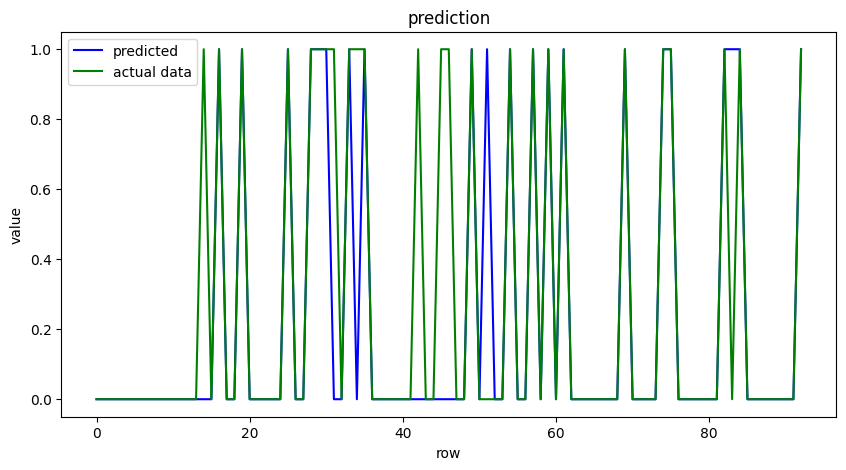

In [ ]:
analyze_model_on_test_set(sequence_cols_25, RNN_bi_path,10,5)

### RNN Summary
1. The performance of the RNN with one feature on the test set is worse than that of a more complex RNN.
2. RNN model with increased units with all 25 features achieves better accuracy and other evaluation metrics
3. When we use more than one layer, the previous layer must be set to return_sequences = True.

# Model Building with LSTM

In [ ]:
# Model - (100 LSTM units with 0.2 dropout) +
#         (50 LSTM units with 0.2 dropout) +
#         (dense layer with sigmoid activation)

features_dim = seq_set_f25.shape[2] # number of features
out_dim = label_set.shape[1] # 1 Label (Target variable is failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

model = Sequential()

# Understanding of return_sequences and connection across LSTM layers
model.add(LSTM(
         input_shape=(sequence_length, features_dim),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Define path to save model
model_path = 'Folder/binary_model.keras'

Features dimension:  25
Output dimension:  1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 100)             │          50,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,651 (315.04 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network
history = model.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/200
75/75 - 6s - 82ms/step - accuracy: 0.9017 - loss: 0.2378 - val_accuracy: 0.9744 - val_loss: 0.0756
Epoch 2/200
75/75 - 2s - 26ms/step - accuracy: 0.9648 - loss: 0.0922 - val_accuracy: 0.9757 - val_loss: 0.0619
Epoch 3/200
75/75 - 1s - 9ms/step - accuracy: 0.9681 - loss: 0.0762 - val_accuracy: 0.9898 - val_loss: 0.0350
Epoch 4/200
75/75 - 1s - 9ms/step - accuracy: 0.9681 - loss: 0.0753 - val_accuracy: 0.9795 - val_loss: 0.0481
Epoch 5/200
75/75 - 1s - 17ms/step - accuracy: 0.9731 - loss: 0.0656 - val_accuracy: 0.9719 - val_loss: 0.0498
Epoch 6/200
75/75 - 1s - 9ms/step - accuracy: 0.9708 - loss: 0.0682 - val_accuracy: 0.9744 - val_loss: 0.0659
Epoch 7/200
75/75 - 1s - 12ms/step - accuracy: 0.9729 - loss: 0.0670 - val_accuracy: 0.9859 - val_loss: 0.0312
Epoch 8/200
75/75 - 1s - 17ms/step - accuracy: 0.9745 - loss: 0.0616 - val_accuracy: 0.9783 - val_loss: 0.0470
Epoch 9/200
75/75 - 1s - 11ms/step - accuracy: 0.9784 - loss: 0.0545 - val_accuracy: 0.9834 - val_loss: 0.0491
Epoc

**Model Evaluation on Validation set**


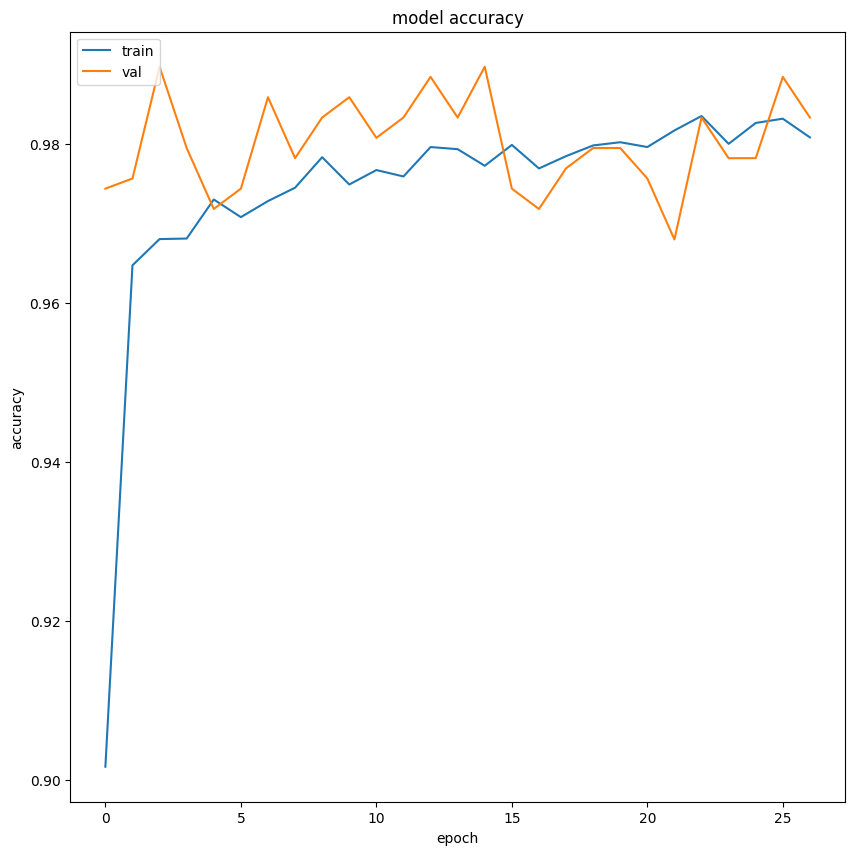

In [ ]:
# Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

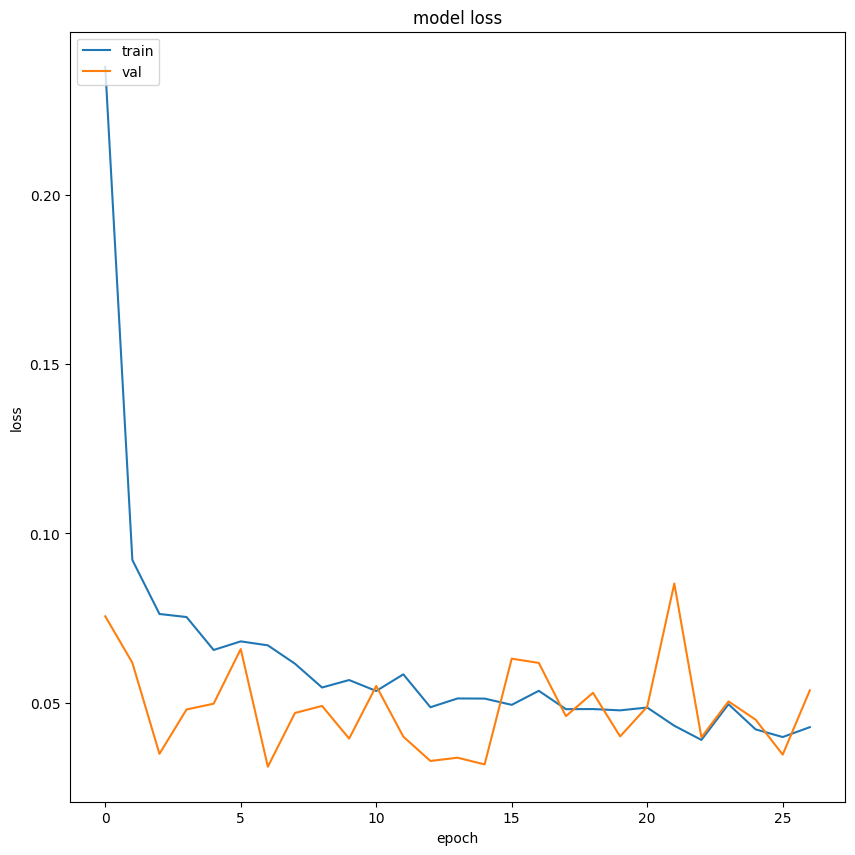

In [ ]:
# Plot model loss for train and test sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Training metrics
scores = model.evaluate(seq_set_f25, label_set, verbose=1, batch_size=50)
print('Train Accurracy: {}'.format(scores[1]))

# Make predictions and compute confusion matrix
y_pred = (model.predict(seq_set_f25, verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_set

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Train Precision = ', precision, '\n', 'Train Recall = ', recall)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9790 - loss: 0.0482
Train Accurracy: 0.9790800213813782
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12493    38]
 [  289  2811]]
Train Precision =  0.9866619866619867 
 Train Recall =  0.9067741935483871


**Model Evaluation on Test set**

3/3 - 0s - 151ms/step - accuracy: 0.9677 - loss: 0.0823
Total time taken for inferencing:  0.50  secs
Test Accurracy: 0.9677419066429138
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 2 23]]
Test Precision:  0.9583333333333334 
 Test Recall:  0.92 
 Test F1-score: 0.9387755102040817


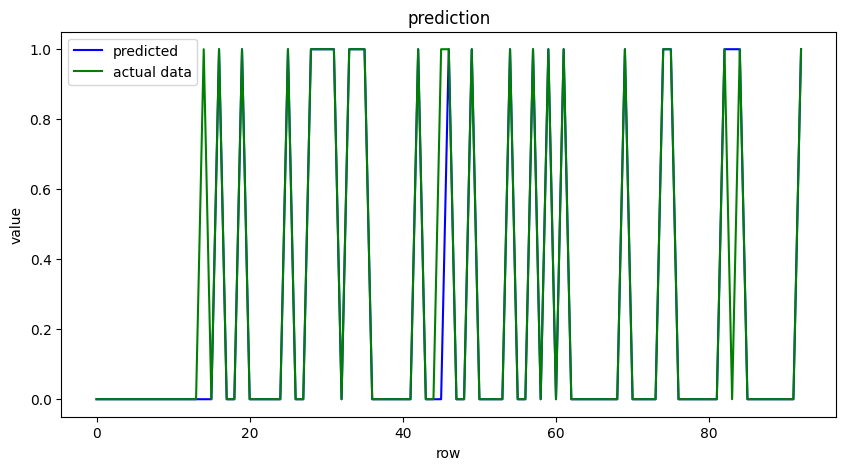

In [ ]:
# Considering all the last sequences of test set
last_test_seq = [test_df[test_df['id']==id][sequence_cols_25].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)

# Get labels of test set
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

# If best model weights were saved then load it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# Test metrics
start = time.time()
scores_test = estimator.evaluate(last_test_seq, last_test_label, verbose=2)
end = time.time()
print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

print('Test Accurracy: {}'.format(scores_test[1]))

# Make predictions and compute confusion matrix
y_pred_test = (estimator.predict(last_test_seq) > 0.5).astype("int32")
y_true_test = last_test_label

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
conf_m = confusion_matrix(y_true_test, y_pred_test)
print(conf_m)

# Compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test,'\n', 'Test F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# Actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()